
# Grocery weekly sales forecast


## 1. Libraries needed

In [2]:
# Import libraries | Standard
import pandas as pd
import numpy as np
import os
import datetime
import warnings
from time import time

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import xgboost as xgb
from lightgbm import LGBMRegressor

# Pretty display for notebooks
%matplotlib inline

## 2. Define Functions

In [3]:
pd.set_option('display.max_columns', None)  
warnings.filterwarnings('ignore')

In [4]:
def distribution(data, features, transformed = False):
    """
    Visualization code for displaying distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(features):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

In [5]:
def eval_train_predict(learner, sample_size, train_X, train_y, test_X, test_y, transform_y, log_constant): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set       
       - train_X: features training set
       - train_y: sales training set
       - test_X: features testing set
       - test_y: sales testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X[:sample_size], train_y[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Weighted Mean Absolute Error on Test Set
    if transform_y == 'log':
        results['WMAE'] = weighted_mean_absolute_error(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant, 
                                                       compute_weights(test_X['IsHoliday']))
    else:
        results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
                   
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [6]:
def eval_visualize(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize = (18,8))

    # Constants
    bar_width = 0.1
    colors = ['#A00000','#00A0A0','#00A000','#E3DAC9','#555555', '#87CEEB']
    metrics = ['time_train', 'time_pred', 'WMAE']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(metrics):
            # Creative plot code
            ax[j%3].bar(0+k*bar_width, results[learner][0][metric], width = bar_width, color = colors[k])
            ax[j%3].set_xlabel("Models")
            ax[j%3].set_xticklabels([''])
                
    # Add unique y-labels
    ax[0].set_ylabel("Time (in seconds)")
    ax[1].set_ylabel("Time (in seconds)")
    ax[2].set_ylabel("WMAE")
    
    # Add titles
    ax[0].set_title("Model Training")
    ax[1].set_title("Model Predicting")
    ax[2].set_title("WMAE on Testing Set")
 
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.43), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [7]:
def train_predict(learner, train_X, train_y, test_X, test_y, transform_y, log_constant, verbose=0): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - train_X: features training set
       - train_y: sales training set
       - test_X: features testing set
       - test_y: sales testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X, train_y)
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Weighted Mean Absolute Error on Test Set
    if transform_y == 'log':
        results['WMAE'] = weighted_mean_absolute_error(np.exp(test_y) - 1 - log_constant, 
                                                       np.exp(predictions) - 1 - log_constant, 
                                                       compute_weights(test_X['IsHoliday']))
    else:
        results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
    

    #Extract the feature importances
    importances = learner.feature_importances_

    # Success
    print("Learner Name :", learner.__class__.__name__)
    print("Training     :", round(results['time_train'],2), "secs /", len(train_y), "records")
    print("Predicting   :", round(results['time_pred'],2), "secs /", len(test_y), "records")
    print("Weighted MAE :", round(results['WMAE'],2))

    if verbose == 1:
        # Plot
        print("\n<Feature Importance>\n")
        feature_plot(importances, train_X, train_y, 10)

        print("\n<Feature Weightage>\n")
        topk = len(train_X.columns)
        indices = np.argsort(importances)[::-1]
        columns = train_X.columns.values[indices[:topk]]
        values = importances[indices][:topk]

        for i in range(topk):
            print('\t' + columns[i] + (' ' * (15 - len(columns[i])) + ': ' + str(values[i])))
            
        print("\n<Learner Params>\n", model.get_params())
    
    # Return the model & predictions
    return (learner, predictions)

In [8]:
def feature_plot(importances, train_X, train_y, topk=5):
    
    # Display the most important features
    indices = np.argsort(importances)[::-1]
    columns = train_X.columns.values[indices[:topk]]
    values = importances[indices][:topk]

    # Creat the plot
    fig = plt.figure(figsize = (18,5))
    plt.title("Normalized Weights for First " + str(topk) + " Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(topk), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(topk) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(topk), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  

In [9]:
def reduce_mem_usage(df, verbose=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
def compute_weights(holidays):
    return holidays.apply(lambda x: 1 if x==0 else 5)

In [11]:
def weighted_mean_absolute_error(pred_y, test_y, weights):
    return 1/sum(weights) * sum(weights * abs(test_y - pred_y))

## 3. Data import & EDA

### 3.1 Store Data

In [12]:
#read data
features = pd.read_csv("data/features.csv")
stores = pd.read_csv("data/stores.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [13]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [14]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [15]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [16]:
#check missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


In [17]:
stores['Size'].groupby(stores['Type']).mean()

Type
A    177247.727273
B    101190.705882
C     40541.666667
Name: Size, dtype: float64

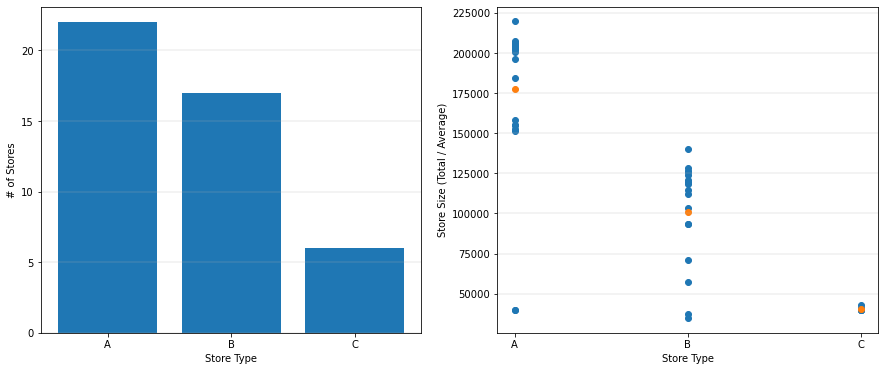

In [18]:
#Create figure
#plt.figure()
#plt.scatter(stores['Type'], stores['Store'])
#plt.ylabel('Store ID')
#plt.xlabel('Store Type')

fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).count())
ax[0].set_ylabel('# of Stores')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].scatter(stores['Type'], stores['Size'])
ax[1].scatter(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).mean()) #Store Type Average Store Size Vs 
ax[1].set_ylabel('Store Size (Total / Average)')
ax[1].set_xlabel('Store Type')
ax[1].yaxis.grid(True, linewidth=0.3)

#plt.figure(figsize=(6,6))
#plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
#plt.xlabel('fraction of rows with missing data')
#plt.barh(np.arange(len(features_missing)), features_missing)

In [19]:
stores[(stores['Size'] < 40000) & (~stores['Type'].isin(['C']))]

,Store,Type,Size
2,3,B,37392
4,5,B,34875
32,33,A,39690
35,36,A,39910


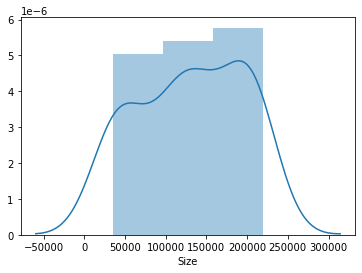

In [20]:
#Explore Weekly Sales using histogram
sns.distplot(stores['Size'])

###### Takeaways: 
1. Column TYPE is a candidate for one-hot encoding.
2. Most stores are of TYPE='A'. Only a few stores are of TYPE='C'.
3. TYPE columns seem to be linked to Store Size. Average store size of TYPE 'A' is ~ 175k, TYPE 'B' is ~ 100k and TYPE 'C' is ~ 40k
4. Four stores [3, 5, 33 & 36] whose size is < 40k, seem to have been incorrectly tagged as Types A & B

### 3.2 Feature Data

In [21]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [22]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [23]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [24]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


In [25]:
# Distribution of NaNs for all columns
features_missing = features.isna().sum()/len(features) * 100

<BarContainer object of 12 artists>

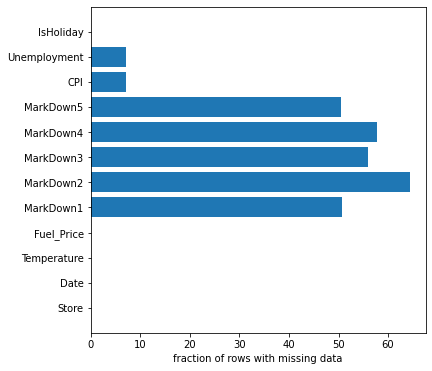

In [26]:
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

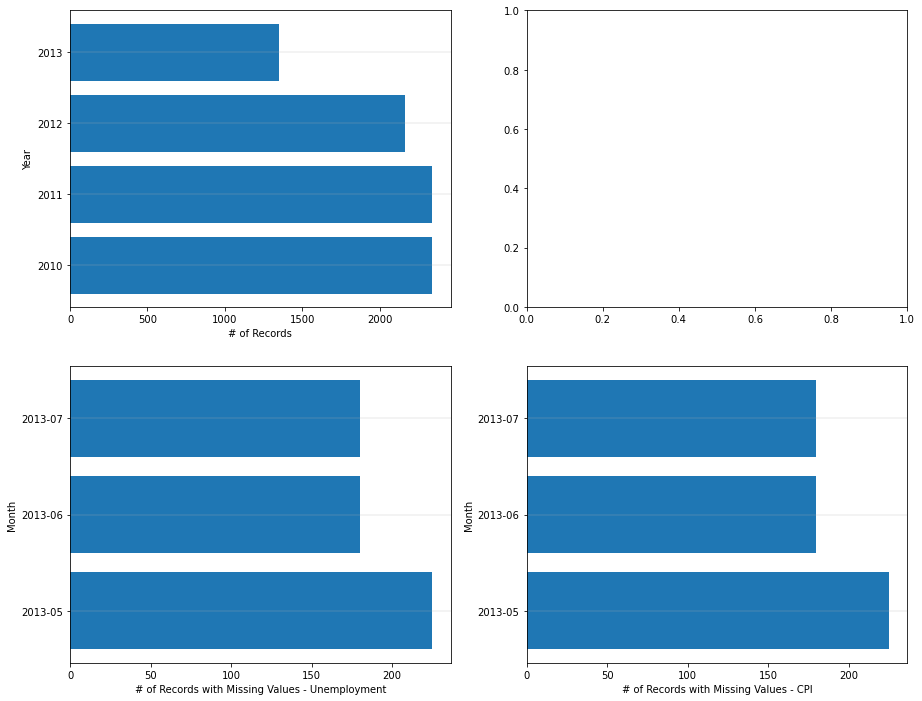

In [33]:
fig, ax = plt.subplots(2, 2, figsize = (15,12))

# Plot 1: Year Vs # of Records
ax[0,0].barh(features['Date'].str.slice(start=0, stop=4).unique(), 
          features['Date'].str.slice(start=0, stop=4).value_counts())
ax[0,0].set_xlabel('# of Records')
ax[0,0].set_ylabel('Year')
ax[0,0].yaxis.grid(True, linewidth=0.3)

# Plot 2: Month Vs # of Records with Missing Values - Unemployment
ax[1,0].barh(features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts())
ax[1,0].set_xlabel('# of Records with Missing Values - Unemployment')
ax[1,0].set_ylabel('Month')
ax[1,0].yaxis.grid(True, linewidth=0.3)

# Plot 3: Month Vs # of Records with Missing Values - CPI
ax[1,1].barh(features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts())
ax[1,1].set_xlabel('# of Records with Missing Values - CPI')
ax[1,1].set_ylabel('Month')
ax[1,1].yaxis.grid(True, linewidth=0.3)

#plt.figure(figsize=(6,6))
#plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
#plt.xlabel('fraction of rows with missing data')
#plt.barh(np.arange(len(features_missing)), features_missing)

In [34]:
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas

In [35]:
# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()

True    585
Name: IsHoliday, dtype: int64

In [36]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

In [37]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
...                   ...           ...
2     2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

In [38]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


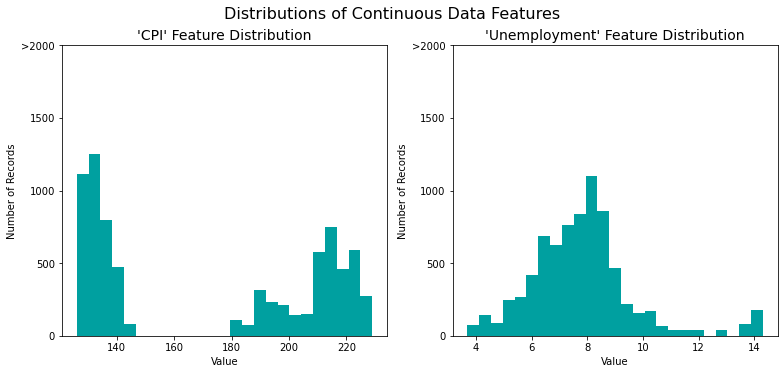

In [39]:
#Explore Distribution
distribution(features, ['CPI','Unemployment'])

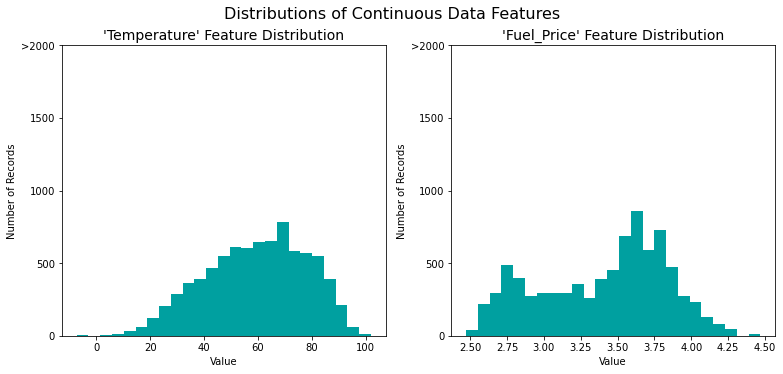

In [40]:
#Explore Distribution
distribution(features, ['Temperature','Fuel_Price'])

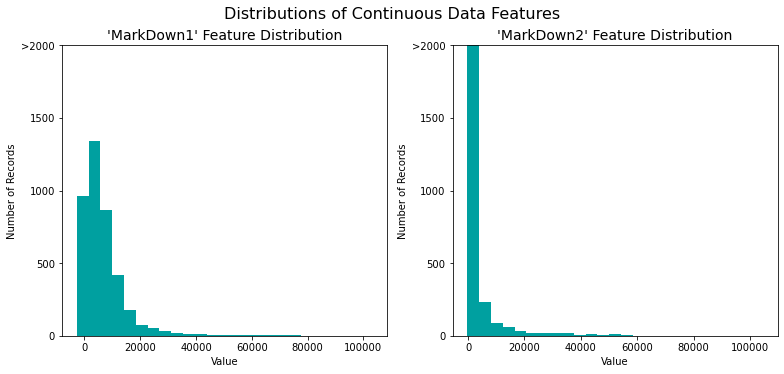

In [41]:
#Explore Distribution
distribution(features, ['MarkDown1','MarkDown2'])

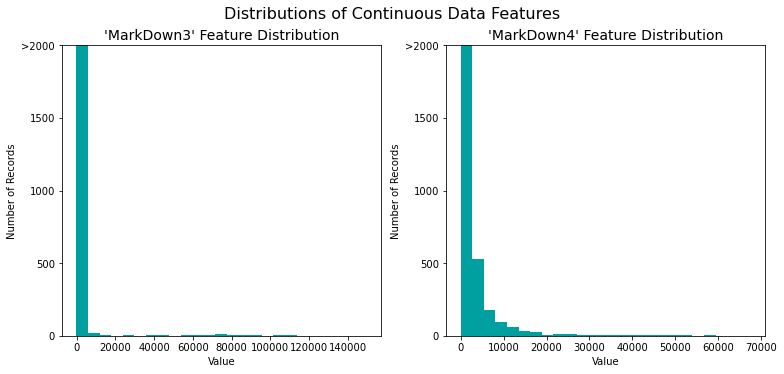

In [42]:
#Explore Distribution
distribution(features, ['MarkDown3','MarkDown4'])

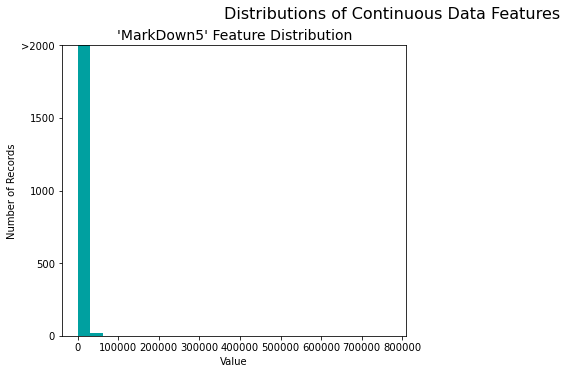

In [43]:
#Explore Distribution
distribution(features, ['MarkDown5'])

###### Takeaways: 
1. Data requires pre-processing
2. Column(s) ISHOLIDAY has been validated
3. Column(s) UNEMPLOYMENT & CPI have missing values for May, Jun & Jul 2013. For these columns as the values dont change significantly month on month, value from Apr 2013 would be propogated over for each store. 
4. Column(s) MARKDOWN* have missing values for 2010 (entire year) and 2011 (until Nov). Additionally, there are missing values for other other dates as well. 
5. CPI and UNEMPLOYMENT value are a bit skewed. MARKDOWN* columns are skewed. 

### 3.3 Train data

In [46]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [48]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [49]:
# Explore Date Range
train['Date'].str.slice(start=0, stop=4).value_counts()

2011    153453
2010    140679
2012    127438
Name: Date, dtype: int64

In [50]:
# Validate Holidays
train['IsHoliday'][train['Date'].isin(holidays)].value_counts()

True    29661
Name: IsHoliday, dtype: int64

In [51]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

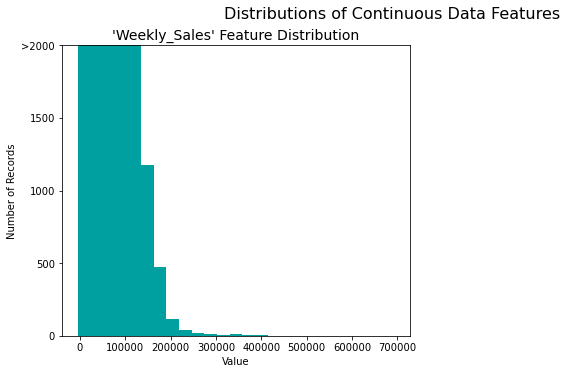

In [52]:
#Explore Distribution
distribution(train, ['Weekly_Sales'])

In [53]:
train['Store'][train['Weekly_Sales'] < 0].count()

1285

In [54]:
train_outliers = pd.merge(train, stores, how='left', on=['Store'])

In [55]:
# Average Weekly Sales by Store Type
train_outliers.groupby(['Type'])['Weekly_Sales'].mean()

Type
A    20099.568043
B    12237.075977
C     9519.532538
Name: Weekly_Sales, dtype: float64

In [56]:
# Average Weekly Sales for possibly misclassified Stores
train_outliers = train_outliers[train_outliers['Store'].isin([3,5,33,36])]
train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean()

Store  Type
3      B       6373.033983
5      B       5053.415813
33     A       5728.414053
36     A       8584.412563
Name: Weekly_Sales, dtype: float64

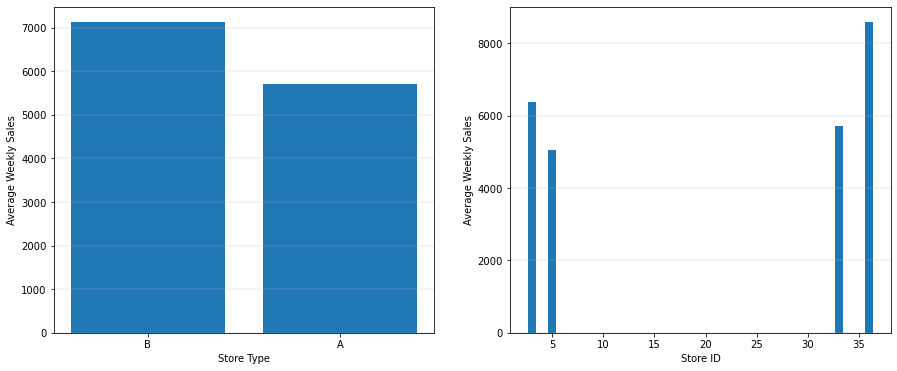

In [57]:
# Average Weekly Sales by Store Type
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(train_outliers['Type'].unique(), train_outliers.groupby(['Type'])['Weekly_Sales'].mean())
ax[0].set_ylabel('Average Weekly Sales')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].bar([3,5,33,36], train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean())
ax[1].set_ylabel('Average Weekly Sales')
ax[1].set_xlabel('Store ID')
ax[1].yaxis.grid(True, linewidth=0.3)

In [58]:
train_outliers = None

###### Takeaways: 
1. Column DATE is non-numeric and is a candidate for pre-processing.
2. 1285 records with Weekly Sales < 0
3. Data spans years 2010, 2011 and 2012
4. As suspected above, four stores [3, 5, 33 & 36] seem to have incorrectly classified as Type A & B. Average Weekly Sales for these stores is in line with the average for Type C. Hence, these would need to be reclassified as Type C.

### 3.4 Test Data

In [59]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [61]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [62]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64

In [63]:
# Validate Holidays
test['IsHoliday'][test['Date'].isin(holidays)].value_counts()

True    8928
Name: IsHoliday, dtype: int64

In [64]:
test['Date'][test['IsHoliday'].isin([1])][~test['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

###### Takeaways: 
1. Column DATE is non-numeric and is a candidate for pre-processing.
2. Data spans years 2012 and 2013

## 4. Data Pre-Processing

### 4.1 Missing/Incorrect Values

#### 4.1.1 Stores Data -- Correct Type for 4 stores

In [66]:
stores[stores['Store'].isin([3,5,33,36])].index
stores.iat[2, 1] = stores.iat[4, 1] = stores.iat[32, 1] = stores.iat[35, 1] = 'C'

In [67]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,C,37392
3,4,A,205863
4,5,C,34875


#### 4.1.2 Features Data -- Negative values for MarkDowns:

In [68]:
features['MarkDown1'] = features['MarkDown1'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown2'] = features['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown3'] = features['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown4'] = features['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown5'] = features['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

Features Data -- NaN values for multiple columns:

Columns: CPI and Unemployment

As noted above, columns are missing values for 3 months May, Jun & Jul 2013. Values from Apr 2019 would be imputated to records with missing values. 

In [69]:
%%time
# For each Store, propogate values of CPI & Unemployment to the rows with NaN values
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

CPU times: user 1.78 s, sys: 10.5 ms, total: 1.79 s
Wall time: 1.79 s


Columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4 & MarkDown5

As noted above, columns MARKDOWN* are missing values for the whole of 2010 and 2011 (upto Nov). For each store, 2012 values would be copied over to records with missing values. Also, to facilitate the copy, new columns WEEK and YEAR would be derived from DATE.

In [70]:
%%time
# For each date, retrive the corresponding week number
features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 2.8 s, sys: 15.6 ms, total: 2.81 s
Wall time: 2.82 s


In [71]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)

In [72]:
#missing data for 2012 & 2013
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [73]:
%%time
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]    

CPU times: user 45.3 s, sys: 302 ms, total: 45.6 s
Wall time: 45.9 s


In [74]:
features.drop(columns=['Year'], axis=1, inplace=True)

In [75]:
# Now fill all the missing MarkDown values with 0
features.fillna(0, inplace=True)

#### 4.1.3 Train Data -- Negative Values for Weekly Sales

In [76]:
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: 0 if x < 0 else x)

### 4.2 Merge Datasets

##### Merge the following datasets:
1. Stores + Features + Train
2. Stores + Features + Test
3. Remove duplicate columns from each dataset

In [77]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [78]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()

0

In [79]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [80]:
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

In [81]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

## 5. Feature Engineering

#### Column #1: IsHoliday
Column has boolean values and would ned converted to numeric.

In [82]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

#### Column #2: Type
Column is categorical and would be converted to numeric via one-hot encoding. 

In [83]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

#### Column #3: Week
New numeric column being created to replace YEAR. 

In [84]:
train['Week'] = test['Week'] = 0

In [85]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 2min 40s, sys: 420 ms, total: 2min 41s
Wall time: 2min 41s


In [86]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 44.9 s, sys: 194 ms, total: 45.1 s
Wall time: 45.2 s


In [87]:
# Create checkpoint
train.to_csv('train_prescaled.csv', index=False)
test.to_csv('test_prescaled.csv', index=False)

In [88]:
# Restore checkpoint
train = pd.read_csv("train_prescaled.csv")
test = pd.read_csv("test_prescaled.csv")

In [89]:
# Create Submission dataframe
submission = test[['Store', 'Dept', 'Date']].copy()
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

In [90]:
train['Year'] = train['Date'].str.slice(start=0, stop=4)
test['Year'] = test['Date'].str.slice(start=0, stop=4)

In [91]:
# Drop non-numeric columns
train.drop(columns=['Date'], axis=1, inplace=True)
test.drop(columns=['Date'], axis=1, inplace=True)

#### 5.1 Log Transform Skewed Features

In [92]:
skewed = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
train[skewed] = train[skewed].apply(lambda x: np.log(x + 1))
test[skewed] = test[skewed].apply(lambda x: np.log(x + 1))

In [93]:
log_constant = 0
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: np.log(x + 1 + log_constant))

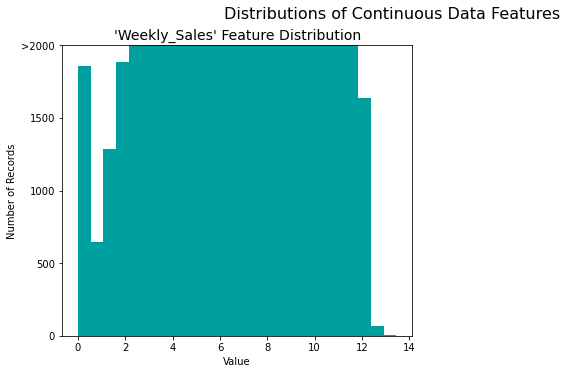

In [94]:
distribution(train, ['Weekly_Sales'])

#### 5.2 Feature Correlation

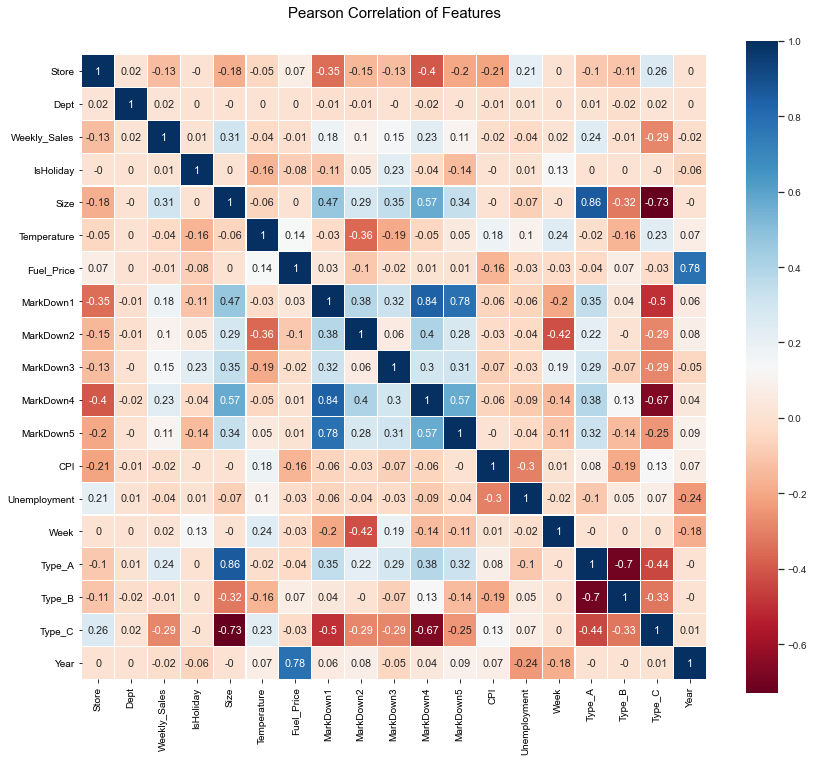

In [95]:
colormap = plt.cm.RdBu
corr = train.astype(float).corr()

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [97]:
corr_cutoff = 0.8
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_cutoff:
            if columns[j]:
                columns[j] = False
                
selected_columns = train.columns[columns]
highcorr_columns = train.columns.difference(selected_columns)

In [98]:
highcorr_columns

Index(['MarkDown4', 'Type_A'], dtype='object')

###### Takeaway: 
1. MarkDown4 and Type_A are highly correlated to other existing features and have been dropped. 

#### 5.3 Split Training dataset into Train & Validation

In [99]:
train_X, val_X, train_y, val_y = train_test_split(train.drop('Weekly_Sales', axis = 1), 
                                                  train['Weekly_Sales'], 
                                                  test_size = 0.2, 
                                                  random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(train_X.shape[0]))
print("Validation set has {} samples.".format(val_X.shape[0]))

Training set has 337256 samples.
Validation set has 84314 samples.


In [100]:
# Validate shape
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test.shape

((337256, 18), (337256,), (84314, 18), (84314,), (115064, 18))

#### 5.4 Scale Datasets

In [101]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical = ['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 
             'CPI', 'Unemployment', 'Week', 'Type_B', 'Type_C',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

train_scaled = pd.DataFrame(data = train_X)
train_scaled[numerical] = scaler.fit_transform(train_X[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
201850,0.454545,0.316327,0.0,0.569925,0.438160,0.272545,0.737133,0.605471,0.125485,0.536298,0.610801,0.844356,0.397642,0.039216,0,1.0,0.0,2011
263688,0.590909,0.581633,0.0,0.916437,0.788454,0.194389,0.890191,0.355430,0.472189,0.790709,0.633988,0.104035,0.393234,0.666667,1,0.0,0.0,2010
147390,0.318182,0.948980,0.0,0.480993,0.604207,0.184369,0.751482,0.262312,0.042536,0.642138,0.635216,0.066155,0.401380,0.745098,0,1.0,0.0,2010
169866,0.386364,0.183673,0.0,0.464300,0.714090,0.579659,0.791126,0.534033,0.072421,0.739553,0.617590,0.119591,0.424094,0.470588,0,1.0,0.0,2012
253398,0.568182,0.551020,0.0,0.636752,0.481703,0.759519,0.664863,0.304229,0.261758,0.289839,0.566154,0.082750,0.377516,0.313725,1,0.0,0.0,2011


In [102]:
val_scaled = pd.DataFrame(data = val_X)
val_scaled[numerical] = scaler.transform(val_X[numerical])

# Show an example of a record with scaling applied
display(val_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
233571,0.522727,0.551020,0.0,0.914461,0.565656,0.861723,0.865404,0.455363,0.443000,0.780269,0.627616,0.083527,0.415277,0.333333,1,0.0,0.0,2011
88992,0.204545,0.102041,0.0,0.496013,0.692955,0.329659,0.805416,0.360259,0.387339,0.680214,0.496319,0.003681,0.491087,0.823529,0,1.0,0.0,2010
367842,0.863636,0.591837,0.0,0.807775,0.834638,0.090681,0.781498,0.476005,0.057754,0.713487,0.802748,0.830627,0.439429,0.470588,1,0.0,0.0,2010
184359,0.409091,0.602041,0.0,0.914461,0.620157,0.714930,0.817083,0.432713,0.224436,0.658706,0.672905,0.101840,0.376366,0.725490,1,0.0,0.0,2011
26175,0.045455,0.448980,0.0,0.013624,0.480724,0.021042,0.693787,0.696427,0.088778,0.699873,0.545715,0.875328,0.334388,0.117647,0,0.0,1.0,2010


In [103]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Year
0,0.0,0.0,0.0,0.630267,0.561448,0.457916,0.774188,0.739500,0.331330,0.737440,0.583883,0.962735,0.258194,0.843137,1,0.0,0.0,2012
1,0.0,0.0,0.0,0.630267,0.619374,0.421844,0.820135,0.702875,0.312245,0.759398,0.643629,0.962918,0.258194,0.862745,1,0.0,0.0,2012
2,0.0,0.0,0.0,0.630267,0.537965,0.390782,0.805763,0.491516,0.390422,0.632548,0.648929,0.963231,0.258194,0.882353,1,0.0,0.0,2012
3,0.0,0.0,1.0,0.630267,0.570352,0.370240,0.595582,0.142152,0.942015,0.481264,0.421811,0.963716,0.258194,0.901961,1,0.0,0.0,2012
4,0.0,0.0,0.0,0.630267,0.532290,0.368236,0.685397,0.000000,0.692664,0.451552,0.652772,0.964200,0.258194,0.921569,1,0.0,0.0,2012


In [104]:
# Free up memory
train = test = features = stores = None

In [105]:
# Create checkpoint
train_scaled.to_csv('train_X_scaled.csv', index=False)
val_scaled.to_csv('val_X_scaled.csv', index=False)
train_y.to_csv('train_y.csv', index=False, header=['Weekly_Sales'])
val_y.to_csv('val_y.csv', index=False, header=['Weekly_Sales'])
test_scaled.to_csv('test_X_scaled.csv', index=False)

In [106]:
# Restore checkpoint
train_scaled = pd.read_csv("train_X_scaled.csv")
val_scaled = pd.read_csv("val_X_scaled.csv")
train_y = pd.read_csv("train_y.csv")
val_y = pd.read_csv("val_y.csv")
test_scaled = pd.read_csv("test_X_scaled.csv")

In [107]:
train_X = train_scaled
val_X = val_scaled

In [108]:
# Convert Dataframe to Series
train_y = train_y.iloc[:,0]
val_y = val_y.iloc[:,0]

## 6. Modelling

### 6.1 Select and evaluate candidate models

In [109]:
%%time
# Initialize base models
model_A = LinearRegression()
model_B = ElasticNet(random_state=1)
model_C = RandomForestRegressor(random_state=1)
model_D = GradientBoostingRegressor(random_state=1)
model_E = xgb.XGBRegressor()
model_F = LGBMRegressor(random_state=1)

samples = len(train_y) # 100% of training set

# Collect results on the learners
results = {}
for model in [model_A, model_B, model_C, model_D, model_E, model_F]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    for i, samples in enumerate([samples]):
        results[model_name][i] = eval_train_predict(model, samples, train_X, train_y, val_X, val_y, 'log', log_constant)

LinearRegression trained on 337256 samples.
ElasticNet trained on 337256 samples.
RandomForestRegressor trained on 337256 samples.
GradientBoostingRegressor trained on 337256 samples.
XGBRegressor trained on 337256 samples.
LGBMRegressor trained on 337256 samples.
CPU times: user 8min 11s, sys: 10.6 s, total: 8min 22s
Wall time: 6min 42s


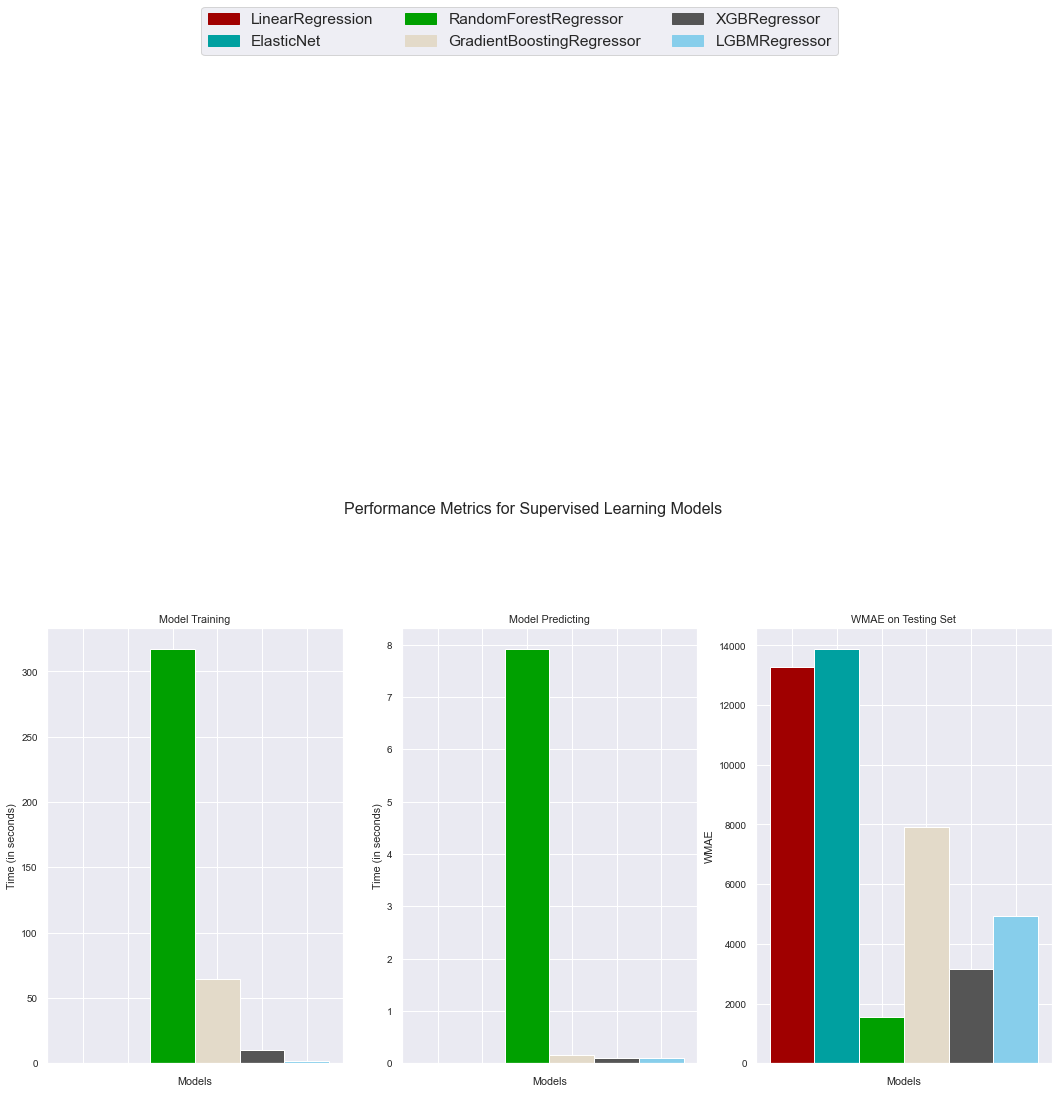

In [110]:
# Evaluate Metrics
eval_visualize(results)

In [111]:
results

{'LinearRegression': {0: {'time_train': 0.21591782569885254,
   'time_pred': 0.015205860137939453,
   'WMAE': 13287.7566071361}},
 'ElasticNet': {0: {'time_train': 0.08503985404968262,
   'time_pred': 0.010167121887207031,
   'WMAE': 13874.268546310475}},
 'RandomForestRegressor': {0: {'time_train': 317.0262517929077,
   'time_pred': 7.911624193191528,
   'WMAE': 1546.7659345441182}},
 'GradientBoostingRegressor': {0: {'time_train': 64.50307178497314,
   'time_pred': 0.16352391242980957,
   'WMAE': 7907.083946706931}},
 'XGBRegressor': {0: {'time_train': 9.897840023040771,
   'time_pred': 0.10136723518371582,
   'WMAE': 3171.0169017839207}},
 'LGBMRegressor': {0: {'time_train': 1.7159531116485596,
   'time_pred': 0.10673928260803223,
   'WMAE': 4940.133304551517}}}

###### Takeaway: With respect to WMAE, Random Forest and Light GBM have turned out to be the top performing base models and would be further evaluated.

### 6.2 Evaluate Random Forest (Ensemble)

#### 6.2.1 Default Model

In [112]:
model_rf_base = RandomForestRegressor(random_state=42, verbose=1)

Learner Name : LGBMRegressor
Training     : 1.01 secs / 337256 records
Predicting   : 0.11 secs / 84314 records
Weighted MAE : 4940.13

<Feature Importance>



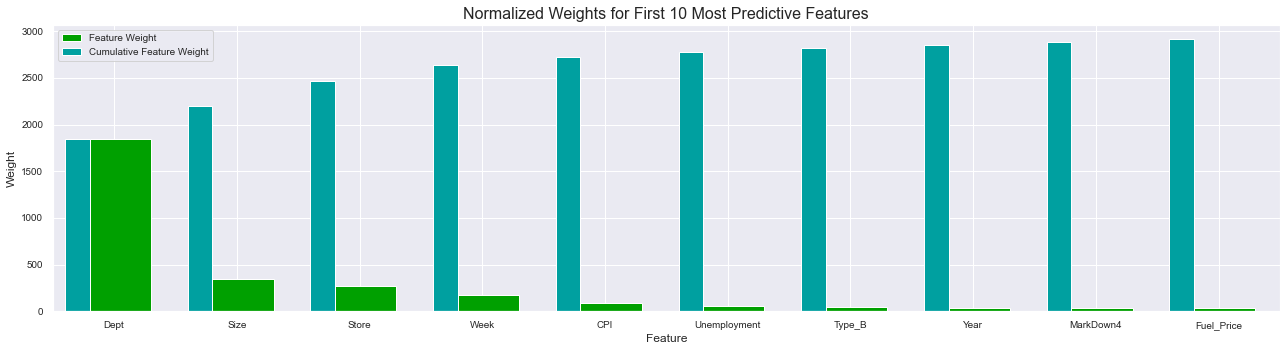


<Feature Weightage>

	Dept           : 1846
	Size           : 348
	Store          : 269
	Week           : 174
	CPI            : 87
	Unemployment   : 53
	Type_B         : 44
	Year           : 33
	MarkDown4      : 32
	Fuel_Price     : 32
	Temperature    : 30
	MarkDown3      : 19
	MarkDown1      : 18
	IsHoliday      : 8
	Type_C         : 4
	MarkDown5      : 2
	MarkDown2      : 1
	Type_A         : 0

<Learner Params>
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 1, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [113]:
model_rf_base, pred_y_rf_val = train_predict(model, train_X, train_y, val_X, val_y, 'log', log_constant, verbose=1)

In [114]:
pred_y_rf_test = model_rf_base.predict(test_scaled)

In [115]:
param_grid = { 
    'n_estimators': [10, 50, 100, 150],
    'max_features': [None, 'auto'],
    'bootstrap': [True, False],
    'max_depth':[None],
    'random_state': [42], 
    'verbose': [1]
}

#### 6.2.2 Tuned Model

In [116]:
model = RandomForestRegressor(random_state=42, 
                              n_estimators=150, 
                              bootstrap=True, 
                              max_features=None, 
                              max_depth=None, 
                              min_samples_leaf=1,
                              min_samples_split=3,
                              verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.0s finished


Learner Name : RandomForestRegressor
Training     : 398.52 secs / 337256 records
Predicting   : 7.97 secs / 84314 records
Weighted MAE : 1547.37

<Feature Importance>



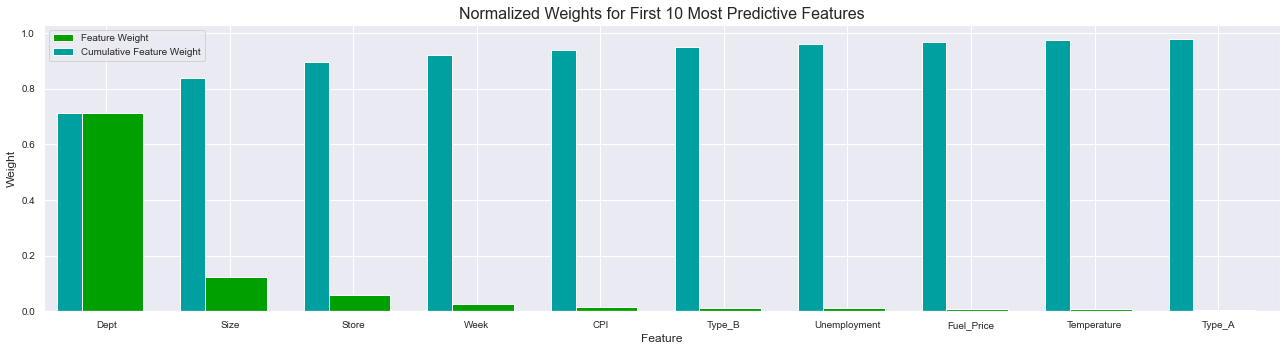


<Feature Weightage>

	Dept           : 0.7123374202616288
	Size           : 0.12494567713040361
	Store          : 0.057425916772044026
	Week           : 0.027233234707863794
	CPI            : 0.015894647387307847
	Type_B         : 0.011629120342949977
	Unemployment   : 0.010288858490305608
	Fuel_Price     : 0.00801334650070296
	Temperature    : 0.0076202090323297285
	Type_A         : 0.004141535652178197
	MarkDown3      : 0.0038610944157934815
	Year           : 0.003347135977496507
	MarkDown5      : 0.003340811925578504
	MarkDown1      : 0.003251965783516592
	MarkDown4      : 0.0031264869138355974
	MarkDown2      : 0.002816637545180674
	Type_C         : 0.0003787753135698076
	IsHoliday      : 0.00034712584731442614

<Learner Params>
 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_w

In [117]:
model, pred_y_rf_val = train_predict(model, train_X, train_y, val_X, val_y, 'log', log_constant, verbose=1)

In [118]:
pred_y_rf_test = model.predict(test_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished


### 6.3 Evaluate Light GBM (Boosting)

#### 6.3.1 Default Model

Learner Name : LGBMRegressor
Training     : 0.91 secs / 337256 records
Predicting   : 0.1 secs / 84314 records
Weighted MAE : 4888.86

<Feature Importance>



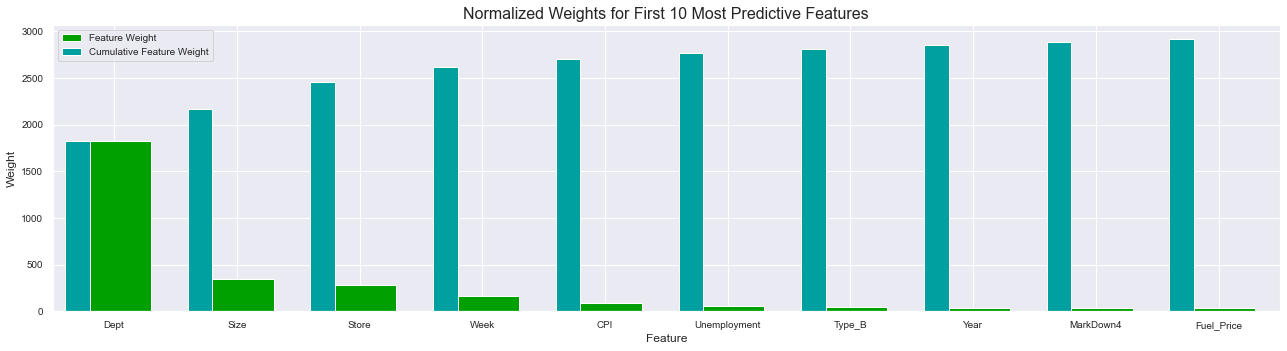


<Feature Weightage>

	Dept           : 1822
	Size           : 348
	Store          : 287
	Week           : 167
	CPI            : 86
	Unemployment   : 61
	Type_B         : 46
	Year           : 36
	MarkDown4      : 35
	Fuel_Price     : 33
	Temperature    : 22
	MarkDown3      : 20
	MarkDown1      : 17
	IsHoliday      : 10
	MarkDown2      : 7
	Type_C         : 3
	MarkDown5      : 0
	Type_A         : 0

<Learner Params>
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [119]:
# Default model
model = LGBMRegressor()
model, pred_y_lgbm_val = train_predict(model, train_X, train_y, val_X, val_y, 'log', log_constant, verbose=1)

In [120]:
param_grid = {
    'boosting_type': ['gbdt'], 
    'objective': ['regression'],
    'random_state': [42],
    'min_data_in_leaf':[3],
    'min_depth':[2],
    'learning_rate': [0.3],
    #'n_estimators': [1000, 3000],
    'n_estimators': [3000],
    #'num_leaves': [60, 70, 80],
    'max_bin': [150,200,255,300]
}

#### 6.3.2 Tuned Model

model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.3, max_depth=-1, min_child_samples=5, min_child_weight=0.001, min_data_in_leaf=2, min_depth=3, min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=80, objective='regression', random_state=42, reg_alpha=0.1, reg_lambda=2, silent=True, subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbose=1)

#Weighted MAE : 1275.72

model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, importance_type='split', learning_rate=0.3, max_depth=-1, min_child_samples=5, min_child_weight=0.001, min_data_in_leaf=2, min_depth=3, min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=80, objective='regression', random_state=42, reg_alpha=0.1, reg_lambda=2, silent=True, subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbose=1)

#Weighted MAE : 1324.72

In [122]:
model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_bin=150,
       max_depth=-1, min_child_samples=5, min_child_weight=0.001,
       min_data_in_leaf=3, min_depth=2, min_split_gain=0.0,
       n_estimators=3000, n_jobs=-1, num_leaves=80, objective='regression',
       random_state=42, reg_alpha=0.1, reg_lambda=2, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)
#Weighted MAE : 1238.72

[LightGBM] [Warning] Unknown parameter: min_depth
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: min_depth
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 18
[LightGBM] [Info] Start training from score 8.501489
Learner Name : LGBMRegressor
Training     : 23.03 secs / 337256 records
Predicting   : 1.46 secs / 84314 records
Weighted MAE : 1465.04

<Feature Importance>



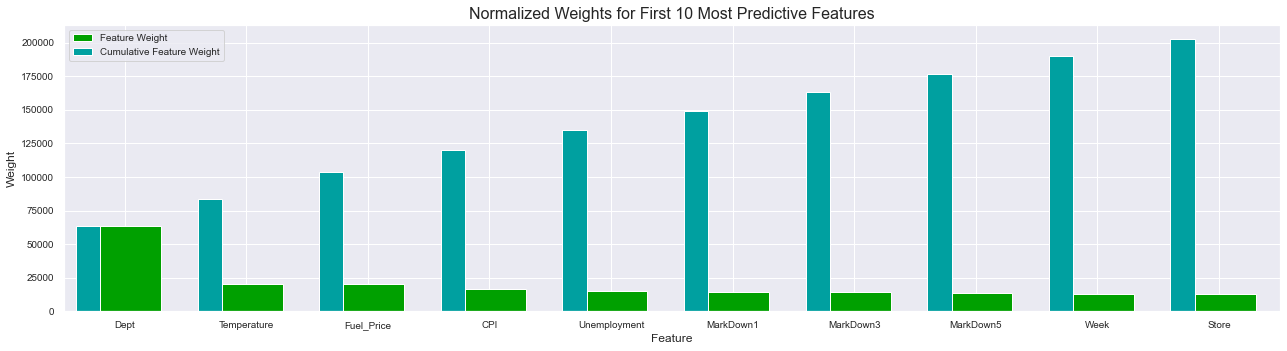


<Feature Weightage>

	Dept           : 63256
	Temperature    : 20199
	Fuel_Price     : 19982
	CPI            : 16410
	Unemployment   : 14798
	MarkDown1      : 14307
	MarkDown3      : 14032
	MarkDown5      : 13899
	Week           : 13119
	Store          : 12884
	MarkDown4      : 11157
	Size           : 10958
	MarkDown2      : 9794
	Year           : 1318
	Type_B         : 495
	IsHoliday      : 362
	Type_A         : 19
	Type_C         : 11

<Learner Params>
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.3, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 3000, 'n_jobs': -1, 'num_leaves': 80, 'objective': 'regression', 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 2, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'max_bin': 150, 'min_data_in_leaf': 3, 'min_depth': 2, 'verbose': 1}


In [123]:
model, pred_y_lgbm_val = train_predict(model, train_X, train_y, val_X, val_y, 'log', log_constant, verbose=1)

In [124]:
pred_y_lgbm_test = model.predict(test_scaled)